In [3]:
from sys import exit
from geopandas import GeoSeries
from shapely.geometry import Point
from math import hypot, floor, ceil
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from numpy import zeros, column_stack
from rasterio import open as rio_open
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from rasterio.plot import show as rio_show
from skimage.draw import line, circle_perimeter
from matplotlib.pyplot import subplots, savefig
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LinearSegmentedColormap

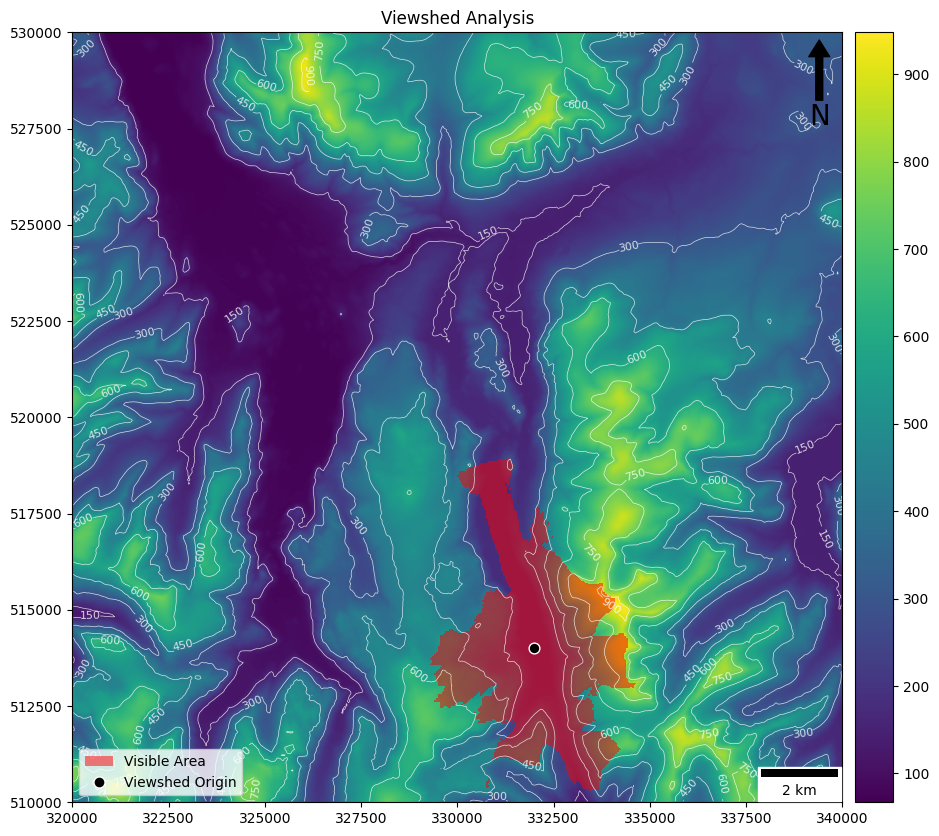

In [4]:
def line_of_sight(r0, c0, height0, r1, c1, height1, radius, dem_data, d, output):
    
    max_dydx = -float('inf')

    for r, c in column_stack(line(r0, c0, r1, c1))[1:]:
        dx = hypot(c0 - c, r0 - r)
    
        if dx > radius or not 0 <= r < d.height or not 0 <= c < d.width:
            break
        
        base_dydx = (dem_data[(r, c)] - height0) / dx
        tip_dydx = (dem_data[(r, c)] + height1 - height0) / dx
    
        if tip_dydx > max_dydx:
            output[(r, c)] = 1

        max_dydx = max(max_dydx, base_dydx)


    return output

def viewshed(x0, y0, radius_m, observer_height, target_height, dem_data, d):

    r0, c0 = d.index(x0, y0)
    
    if not 0 <= r0 < d.height or not 0 <= c0 < d.width:
        print(f"Sorry, {x0, y0} is not within the elevation dataset.")
        exit()
        
    radius_px = int(radius_m / d.res[0])

    height0 = dem_data[(r0, c0)] + observer_height

    output = zeros(dem_data.shape)
    
    output[(r0, c0)] = 1
    
    for r, c in column_stack(circle_perimeter(r0, c0, radius_px*3)):

        output = line_of_sight(r0, c0, height0, r, c, target_height, radius_px, dem_data, d, output)

    return output

with rio_open("D:/Understanding GIS/week 8/helvellyn/Helvellyn-50.tif") as d:

	# read the data out of band 1 in the dataset
	dem_data = d.read(1)

	# set origin for viewshed
	x0, y0 = 332000, 514000

	# calculate the viewshed
	output = viewshed(x0, y0, 5000, 1.8, 100, dem_data, d)

	# output image
	fig, my_ax = subplots(1, 1, figsize=(16, 10))
	my_ax.set_title("Viewshed Analysis")

	# draw dem
	rio_show(
		dem_data,
		ax=my_ax,
		transform = d.transform,
		cmap = 'viridis',
		)

	# draw dem as contours
	rio_show(
		dem_data,
		ax=my_ax,
		contour=True,
		transform = d.transform,
		colors = ['white'],
		linewidths = [0.5],
		)

	# add viewshed
	rio_show(
		output,
		ax=my_ax,
		transform=d.transform,
		cmap = LinearSegmentedColormap.from_list('binary_viewshed', [(0, 0, 0, 0), (1, 0, 0, 0.5)], N=2)
		)

	# add origin point
	GeoSeries(Point(x0, y0)).plot(
		ax = my_ax,
		markersize = 60,
		color = 'black',
		edgecolor = 'white'
		)

	# add a colour bar
	fig.colorbar(ScalarMappable(norm=Normalize(vmin=floor(dem_data.min()), vmax=ceil(dem_data.max())), cmap='viridis'), ax=my_ax, pad=0.01)

	# add north arrow
	x, y, arrow_length = 0.97, 0.99, 0.1
	my_ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
		arrowprops=dict(facecolor='black', width=5, headwidth=15),
		ha='center', va='center', fontsize=20, xycoords=my_ax.transAxes)

	# add scalebar
	my_ax.add_artist(ScaleBar(dx=1, units="m", location="lower right"))

	# add legend for point
	my_ax.legend(
		handles=[
			Patch(facecolor=(1, 0, 0, 0.5), edgecolor=None, label=f'Visible Area'),
			Line2D([0], [0], marker='o', color=(1,1,1,0), label='Viewshed Origin', markerfacecolor='black', markersize=8)
		], loc='lower left')